# Comparing Task-Optimized RNN to Neural Data

<a href="https://colab.research.google.com/github/diffscore/diffscore/blob/master/examples/rnn-data-similarity-mante2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


This notebook illustrates how to use the package to train an RNN on a contextual decision making task and comparing it to the [Mante2013](https://www.nature.com/articles/nature12742) dataset using similarity measures.

It uses [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) and will use the GPU if available.

Install requirements (if not already installed):

In [ ]:
!git clone https://github.com/diffscore/diffscore.git
%cd diffscore
!pip install -e .

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping

from neurogym.utils import plot_env

from diffscore.training import NGymLitTrainer, record_ngym_lit
from diffscore.nn import CTRNN, IterateInput
from diffscore import Env, Dataset, Measure
from diffscore.env import trial_choice_acc

## Training the RNN

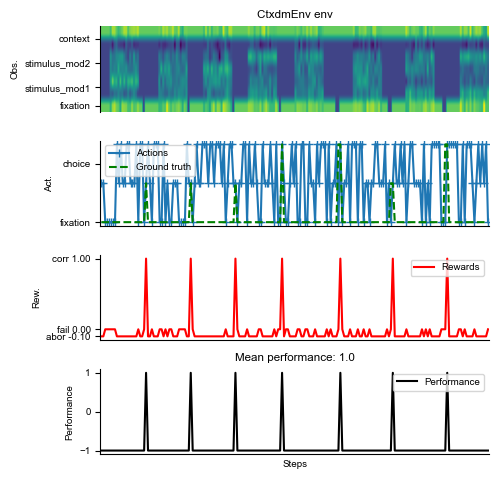

In [2]:
# make the env
env = Env("mante")

# visualize the task
plot_env(env)
plt.show()

In [ ]:
# make the model
model = CTRNN(
    input_size=env.observation_space.shape[0],
    hidden_size=100,
    output_size=env.action_space.n,
    tau=100,
    dt=env.dt
)
model = IterateInput(model)  # run the RNN over the input sequence

# make the trainer
trainer = NGymLitTrainer(
    loss_fn="CrossEntropyLoss",
    accuracy=trial_choice_acc,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor="train_accuracy", mode="max", stopping_threshold=0.93, patience=np.inf)
    ]
)

# train the model on the environment (should take a few minutes)
trainer.fit(model, env)

## Evaluating the RNN

First, we need to record the activity of the RNN for the same set of conditions as the Mante2013 dataset.

In [4]:
# load the neural dataset
neural_dataset = Dataset("Mante2013", for_decoding=False)

In [5]:
# record on the test environment (fixed trial period durations)
test_env = Env("mante-test")

conditions = neural_dataset["trial_info"]
for cond in conditions:
    # fix target positions
    cond["theta1"] = 0
    cond["theta2"] = math.pi

# time window when the activity is recorded in a trial
record_window = (350, 350+750)

model_dataset = record_ngym_lit(
    model=model,
    env=test_env,
    conditions=conditions,
    record_window=record_window
)

Visualize the low-dimensional dynamics of the data and the RNN using the Targeted Dimensionality Reduction method from the paper.

In [ ]:
from diffscore.dataset.mante2013 import mante2013_tdr

dt = neural_dataset["dt"]
mante2013_tdr(neural_dataset["activity"], trial_conditions=neural_dataset["conditions"], dt=dt)
plt.show()

In [ ]:
mante2013_tdr(model_dataset["activity"], trial_conditions=model_dataset["conditions"], dt=dt)
plt.show()

Quantify the similarity using similarity measures.

In [ ]:

X = model_dataset["activity"]
Y = neural_dataset["activity"]

proc_measure = Measure("procrustes-angular-score")
cka_measure = Measure("cka")

proc_score = proc_measure(X, Y)
print("Procrustes angular score:", proc_score.item())

cka_score = cka_measure(X, Y)
print("CKA score:", cka_score.item())